Load everything we need

In [1]:
%run Functions.ipynb

SlowestLapTimes = pd.read_csv("f1db_csv/SlowestLapTimes.csv")
FinishersLapTimes = pd.read_csv("f1db_csv/FinishersLapTimes.csv")

We will plot 3 heatmaps for all the races in the season. One will have all the drivers, with missing laps filled by the Slowest Time method. The second heatmap will only have the drivers that finished the race, including those that were one or mor laps behind. The last heatmap won't have any missing laps filled in.

We can also choose to save them to files, or to just display them on screen.

In [2]:
races = range(989,1010)

distances_s = {}
drivers_s = {}

distances_f = {}
drivers_f = {}

distances = {}
drivers = {}

for race in races:
    # Calculate distance matrices (season=False because we're doing this for individual races)
    distance_s, driver_s = race_distances(race, df=SlowestLapTimes)
    distance_f, driver_f = race_distances(race, df=FinishersLapTimes)
    distance, driver = race_distances(race, df=lap_times)
    
    # Save the results
    distances_s[race] = distance_s
    drivers_s[race] = driver_s
    
    distances_f[race] = distance_f
    drivers_f[race] = driver_f
    
    distances[race] = distance
    drivers[race] = driver
    
    print(race, end="; ")

989; 990; 991; 992; 993; 994; 995; 996; 997; 998; 999; 1000; 1001; 1002; 1003; 1004; 1005; 1006; 1007; 1008; 1009; 

### Heatmaps!
Change this variable if you want to save the heatmaps to an external file.

In [3]:
save_to_file = False

No, we're not


/home/MRGomez/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


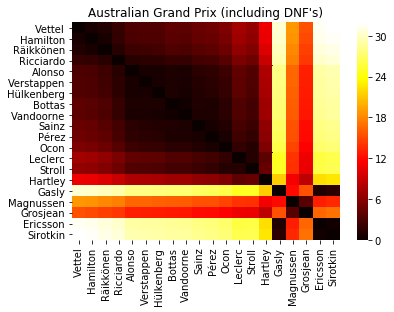

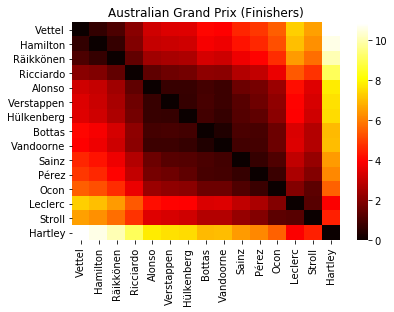

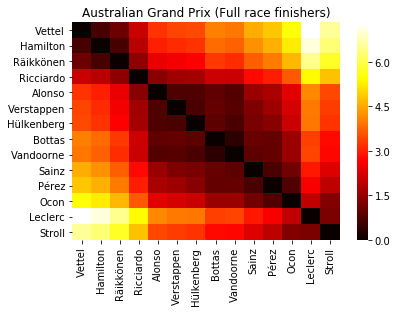

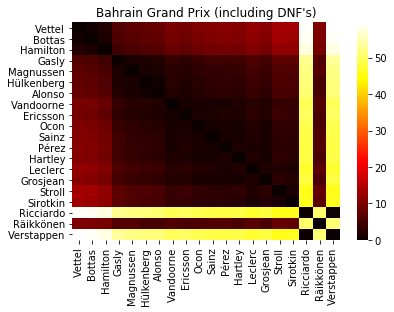

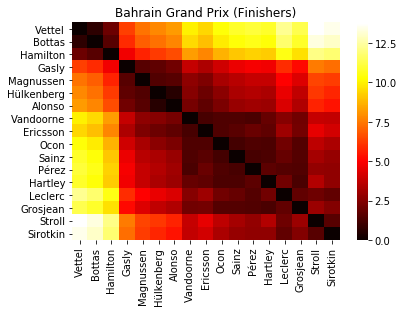

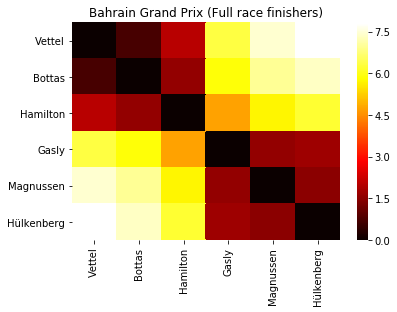

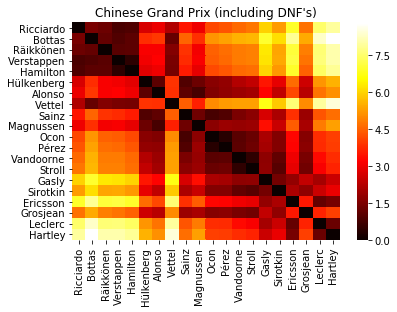

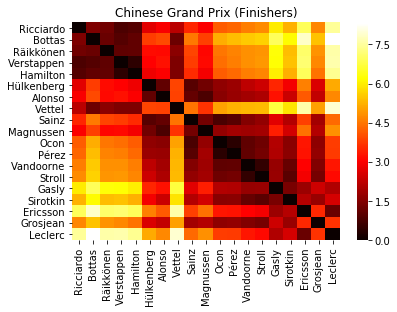

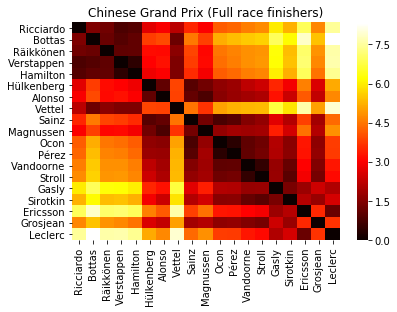

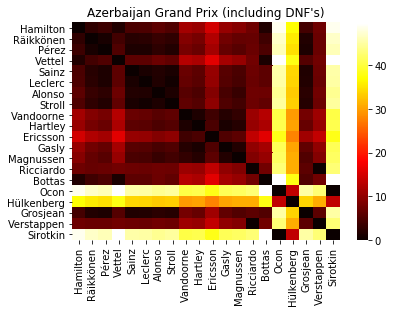

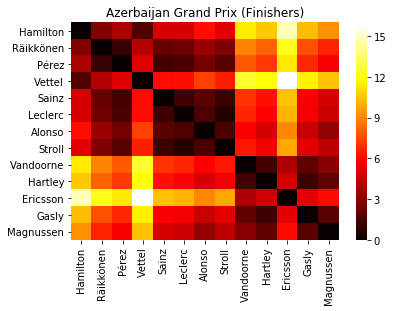

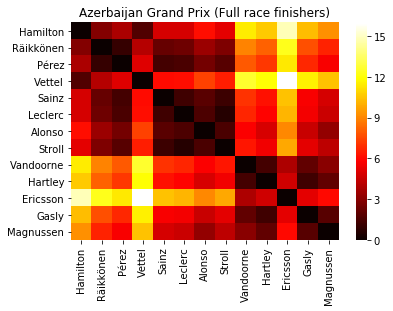

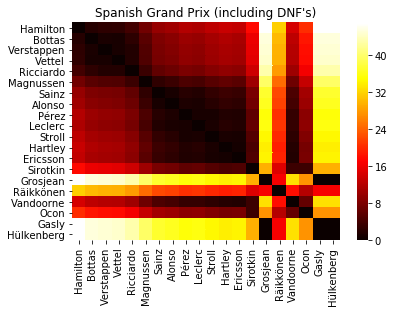

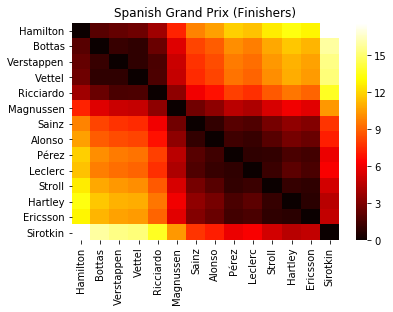

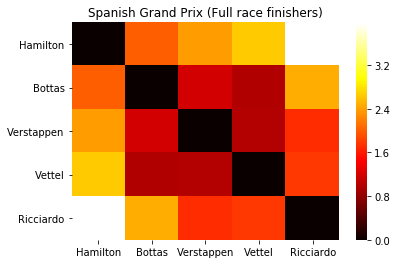

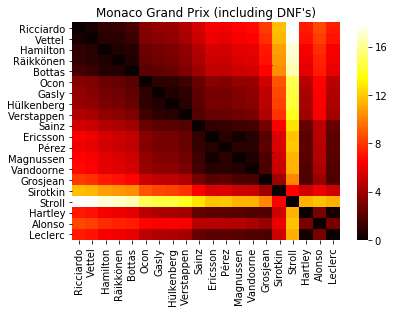

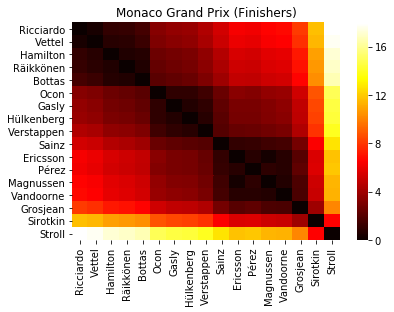

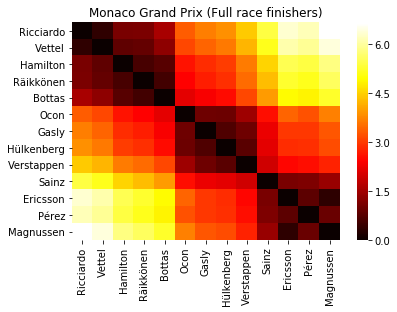

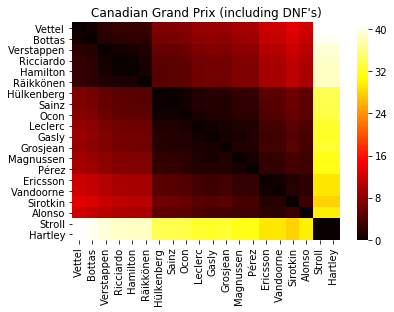

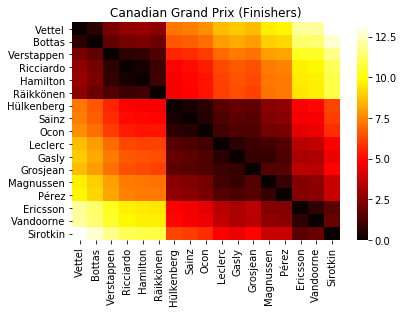

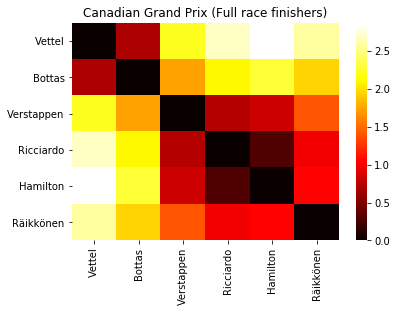

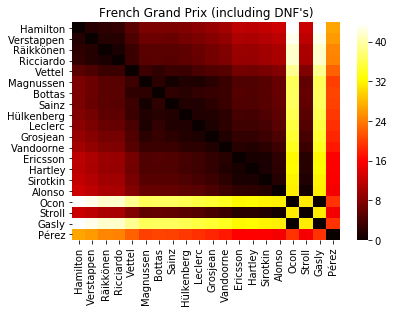

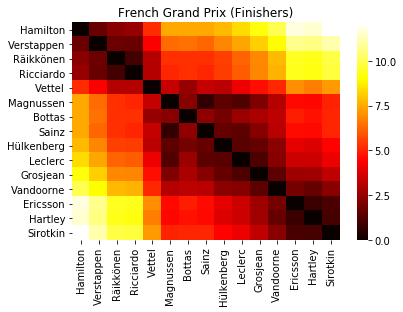

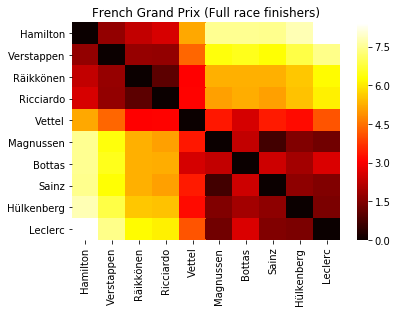

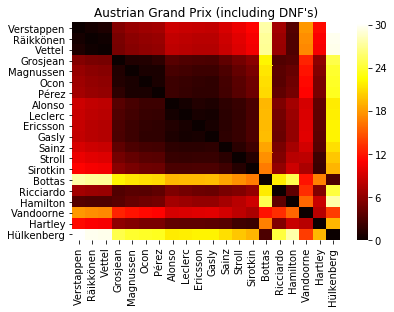

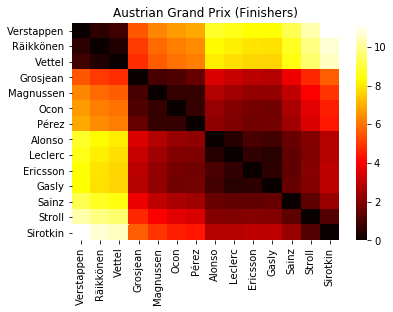

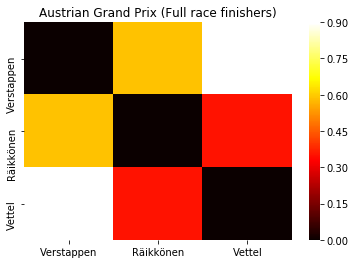

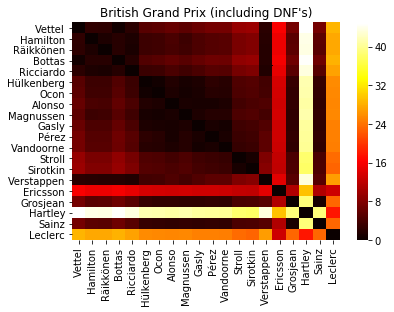

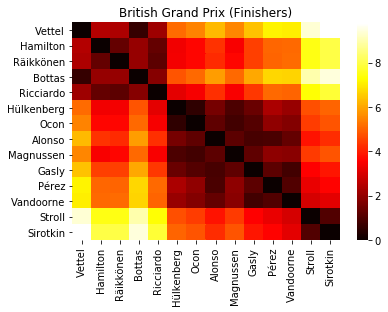

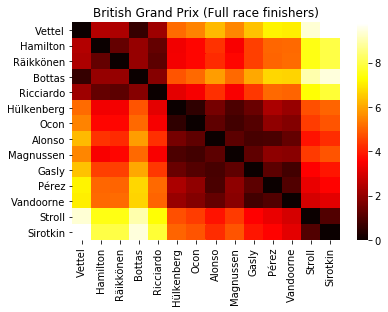

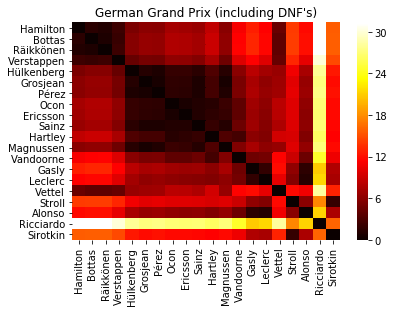

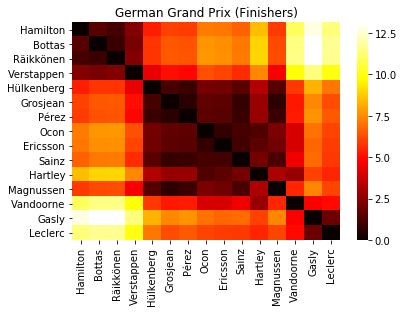

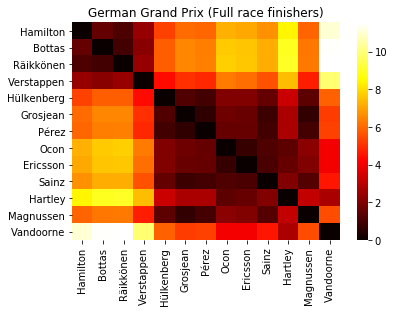

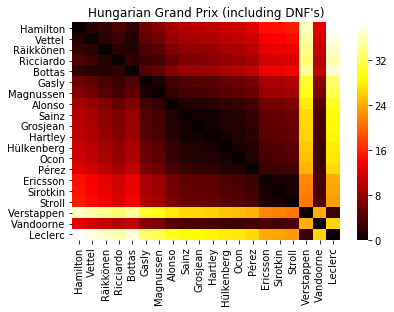

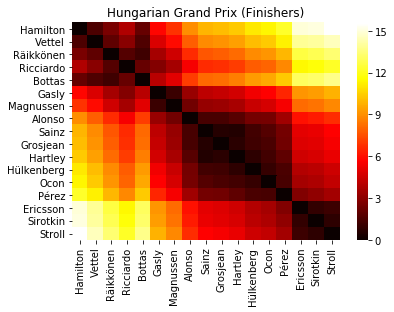

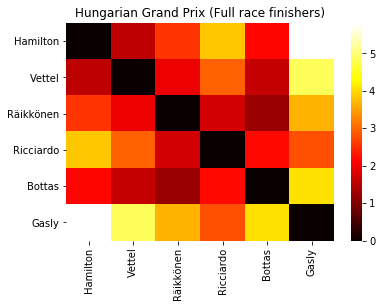

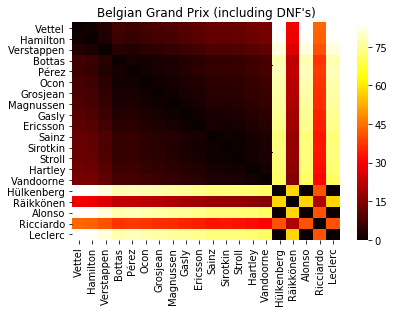

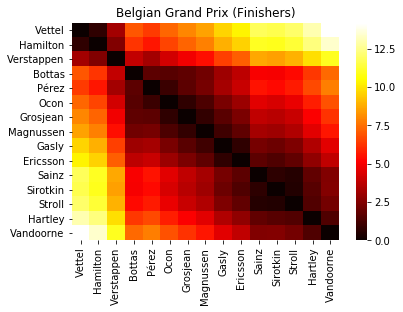

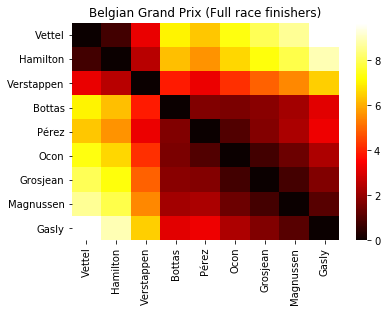

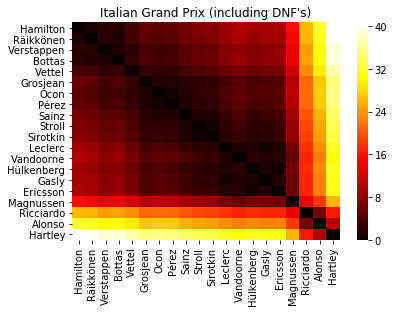

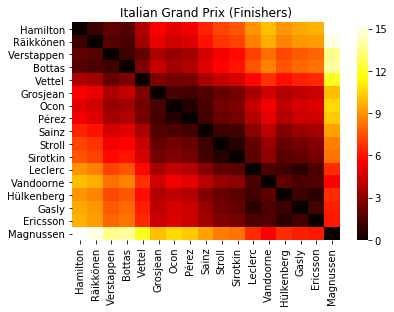

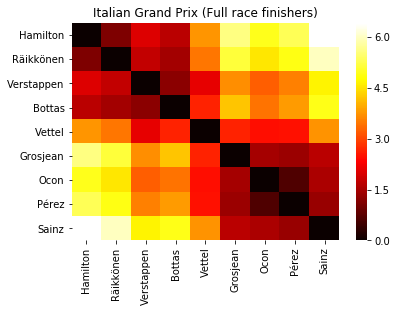

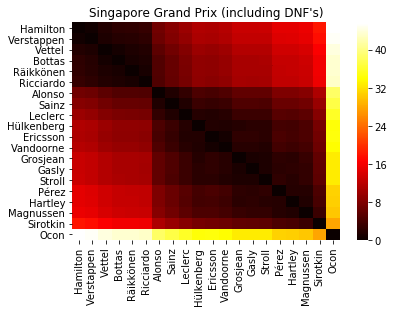

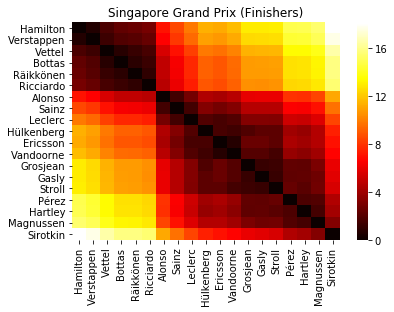

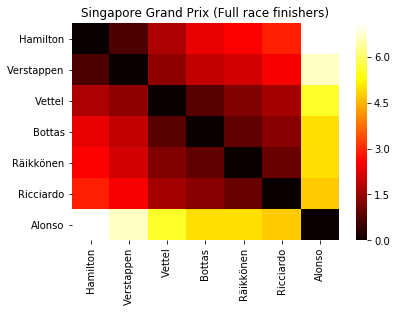

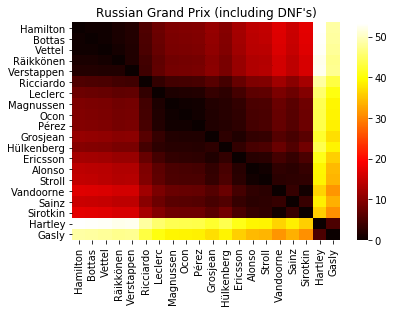

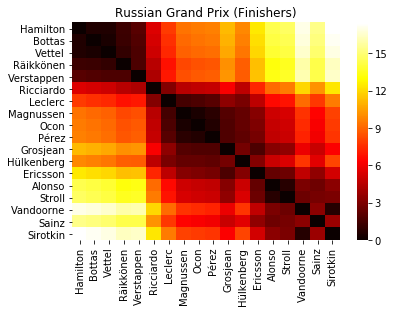

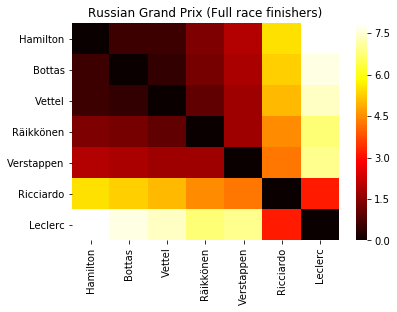

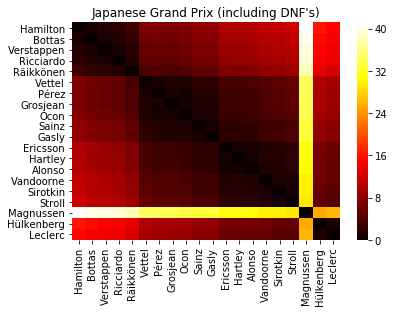

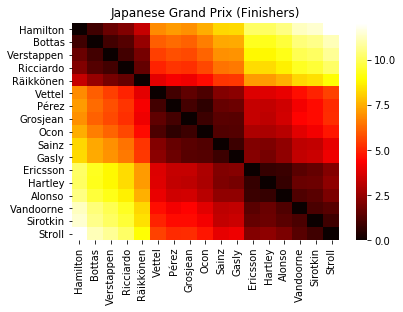

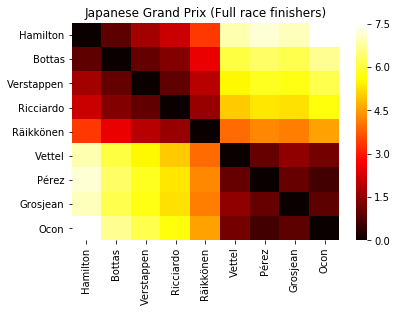

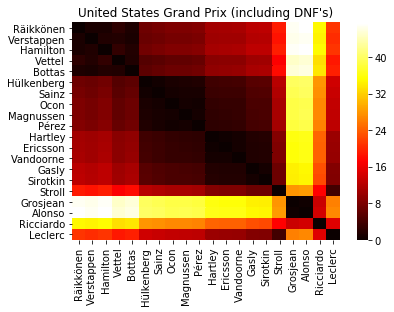

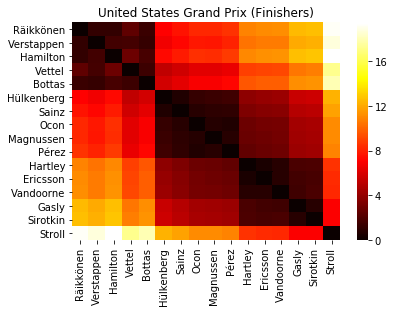

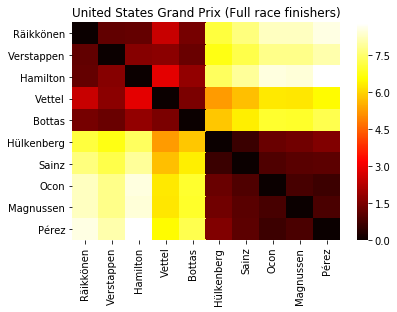

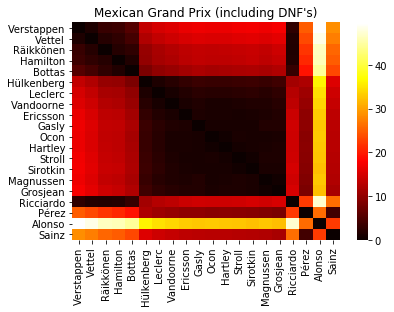

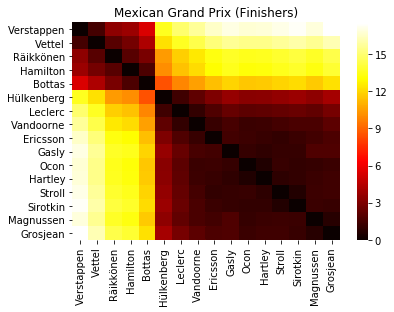

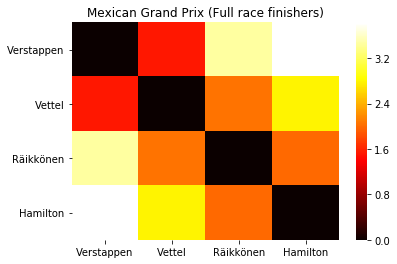

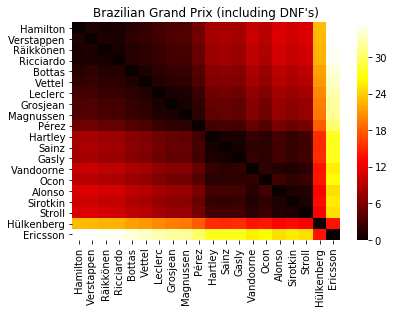

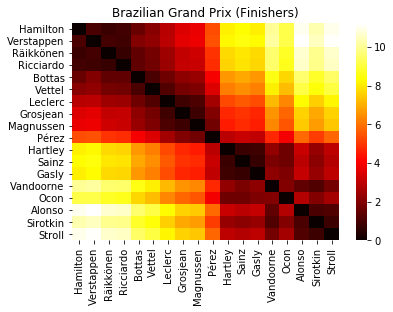

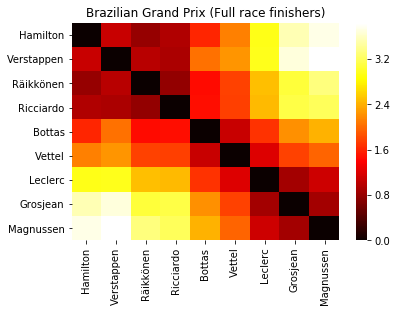

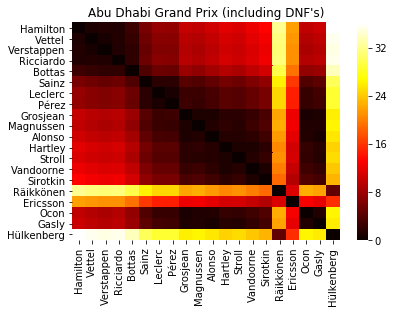

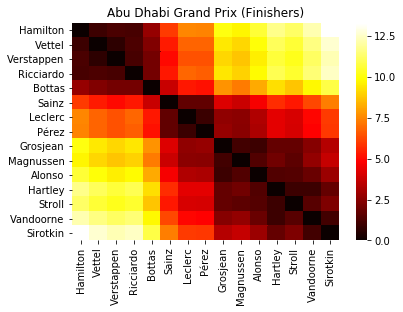

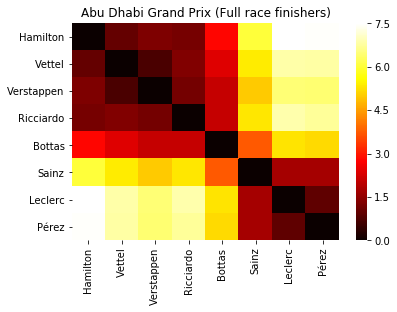

In [4]:
if(save_to_file):
    print("Saving to files!")
else:
    print("No, we're not")

for race in races:
    names_s = [driver_name(id) for id in drivers_s[race]]
    names_f = [driver_name(id) for id in drivers_f[race]]
    names = [driver_name(id) for id in drivers[race]]
    
    # Heatmap for all drivers
    plt.figure()
    plot_s = sns.heatmap(distances_s[race], cmap="hot",
            xticklabels=names_s, yticklabels=names_s)
    plt.title(race_name(race) + " (including DNF's)")
    
    # Heatmap for finishers
    plt.figure()
    plot_f = sns.heatmap(distances_f[race], cmap="hot",
            xticklabels=names_f, yticklabels=names_f)
    plt.title(race_name(race) + " (Finishers)")
    
    # Heatmap with no filled in laps
    plt.figure()
    plot_0 = sns.heatmap(distances[race], cmap="hot",
                xticklabels=names, yticklabels=names)
    plt.title(race_name(race) + " (Full race finishers)")
    
    if(save_to_file):
        # All drivers
        figure = plot_s.get_figure()
        figure.savefig("results/(" + str(race) +") " + race_name(race) + " (including DNF\'s).png",
                       bbox_inches='tight')
        
        # Finishers
        figure = plot_f.get_figure()
        figure.savefig("results/(" + str(race) +") " + race_name(race) + " (Finishers).png",
                       bbox_inches='tight')
        
        # Full race finishers
        figure = plot_0.get_figure()
        figure.savefig("results/(" + str(race) +") " + race_name(race) + " (Full race finishers).png",
                       bbox_inches='tight')

## A specific case
This bit was used in the project presentation. It shows an interesting case that we detected.

Even though our attempted drivers ranking doesn't seem to work that well with the whole season metric, it gives interesting results in single races. An example is the 2018 Australian Grand Prix. Charles Leclerc and Lance Stroll finished in 13th and 14th place, respectively. However, if we use our ranking, they swap positions: Leclerc is below Stroll. How did this happen?

**Note:** This also happened between Bottas and Vandoorne, but that case does not have such a dramatic difference as this one.

In [5]:
_, fp, dists, rankings = extractdiam(distances_f[989])
rankings = [l[0][0] for l in rankings]

aus_metric = sort_matrix(distances_f[989], rankings)
aus_names = [driver_name(id) for id in drivers_f[989]]
aus_names = [aus_names[i] for i in rankings]

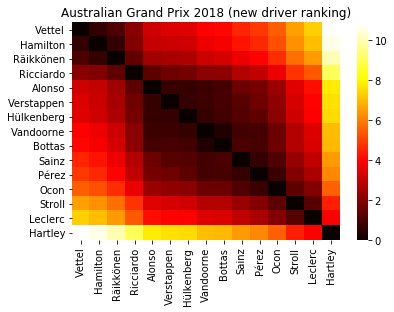

In [6]:
plot1 = sns.heatmap(aus_metric, cmap="hot", xticklabels=aus_names, yticklabels=aus_names)
plt.title("Australian Grand Prix 2018 (new driver ranking)")

if(save_to_file):
    figure = plot1.get_figure()
    figure.savefig("results/Australian Grand Prix 2018 (new driver ranking).png",
                   bbox_inches='tight')

Well, the answer is in how we're measuring the distance between drivers. The graph below shows both drivers' gap to first place. Before there was a safety car in lap 30 (the large drop in the curves), Leclerc was behind Stroll by a decent margin. It was only after the safety car came out that Leclerc got past his opponent, but even then, the two drivers were very close until the end of the race. 

On the other hand, our metric measures, in a way, the area between these two curves. This gives a geometric interpretation of our proposed ranking. Faster drivers are those that have the smallest area under the curve! This explains what is going on between our confused drivers. Stroll has a smaller area under the curve, so we rank him above Leclerc.

In racing terms, Leclerc was behind Stroll in the first half of the race, and then they were very close. *On average*, Stroll was ahead of Leclerc!

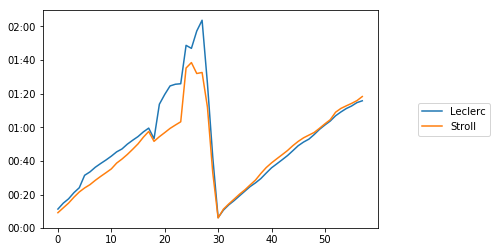

In [7]:
# Compare Leclerc (844) and Stroll (840) in Australia
deltas, _ = delta_to_first(989)

formatter = FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
fig, ax = plt.subplots();

for driver in [844, 840]:
    plt.plot(deltas[driver], label=driver_name(driver))

    ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))

    ax.yaxis.set_major_formatter(formatter)

if(save_to_file):
    plot = plt.gcf()
    plt.savefig("results/Leclerc vs Stroll.png", bbox_inches='tight')

#### Why does the ranking use area under the curve?
To understand this, we add the curve for P1 to our plot. Let $L$, $S$, $V$ be the curves for Leclerc, Stroll, and Vettel, respectively. Technically, Stroll ranks higher according to us because there is less area between $S$ and $V$ than area between $L$ and $V$. However, since we are comparing both curves to $V$, we just skip that step and directly compare the area under $S$ with the area under $L$.

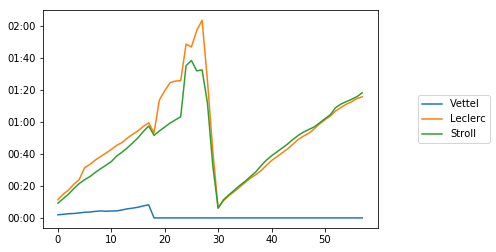

In [8]:
# Compare Vettel (20), Leclerc (844), Stroll (840) in Australia
deltas, _ = delta_to_first(989)

formatter = FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
fig, ax = plt.subplots();

for driver in [20, 844, 840]:
    plt.plot(deltas[driver], label=driver_name(driver))

    ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))

    ax.yaxis.set_major_formatter(formatter)

if(save_to_file):
    plot = plt.gcf()
    plt.savefig("results/Leclerc vs Stroll.png", bbox_inches='tight')